# Classifying Documents

In this notebook we demonstrate a basic document level classification of reports with respect to a single finding ( fever). We leverage the convenience of Pandas to read our data from a SQLite database and then use Pandas to add our classification as a new column in the dataframe.

Many of the common pyConTextNLP tasks have been wrapped into functions contained in the [``radnlp``](https://github.com/chapmanbe/RadNLP) pacakge. We important multiple modules that will allow us to write concise code.

In [1]:
import pyConTextNLP.pyConTextGraph as pyConText
import pyConTextNLP.itemData as itemData
import pymysql
import numpy as np
import os
import radnlp.io  as rio
import radnlp.view as rview
import radnlp.rules as rules
import radnlp.schema as schema
import radnlp.utils as utils
import radnlp.split as split
import radnlp.classifier as classifier
import pandas as pd
from IPython.display import clear_output, display, HTML, Image
from IPython.html.widgets import interact, interactive, fixed
from IPython.display import clear_output
import ipywidgets as widgets
from radnlp.data import classrslts 
import networkx as nx
conn = pymysql.connect(host="mysql",
                       port=3306,user="jovyan",
                       passwd='jovyan',db='mimic2')

/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
conn = pymysql.connect(host="mysql",
                       port=3306,user="jovyan",
                       passwd='jovyan',db='mimic2')

In [63]:
colors={"pulmonary_embolism":"blue",
        "pneumonia":"blue",
        "pneumothorax":"blue",
        "diverticulitis":"blue",
       "definite_negated_existence":"red",
       "probable_negated_existence":"indianred",
       "ambivalent_existence":"orange",
       "probable_existence":"forestgreen",
       "definite_existence":"green",
       "historical":"goldenrod",
       "indication":"Pink",
       "acute":"golden"}

In [4]:
import radnlp
radnlp.__version__

'0.2.0.8'

### Explanation of ``getOptions``

This is just kind of a port of a command line application where I'd use argparse to get the options.


In [51]:
def getOptions():
    """Generates arguments for specifying database and other parameters"""
    options = {}
    options['lexical_kb'] = ["https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/lexical_kb_05042016.tsv"]
    options['domain_kb'] = ["https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/critical_findings.tsv"]
    options["schema"] = "https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/schema2.csv"
    options["rules"] = "https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/classificationRules3.csv" 
    return options

#### Explation of ``get_kb_rules_schema``

* ``itemData.instantiateFromCSVtoitemData``: This function is a somewhat unfortunate name as it implies reading CSV files but we've moved to tab delimited files, since we sometimes have commas in the regular expressions.


In [52]:
def get_kb_rules_schema(options):
    """
    Get the relevant kb, rules, and schema.
    
    """

    _radnlp_rules = rules.read_rules(options["rules"])
    _schema = schema.read_schema(options["schema"])
    
    modifiers = itemData.itemData()
    targets = itemData.itemData()
    for kb in options['lexical_kb']:
        modifiers.extend( itemData.instantiateFromCSVtoitemData(kb) )
    for kb in options['domain_kb']:
        targets.extend( itemData.instantiateFromCSVtoitemData(kb) )
    return {"rules":_radnlp_rules,
            "schema":_schema,
            "modifiers":modifiers,
            "targets":targets}
    

In [53]:

def analyze_report(report, modifiers, targets, rules, schema):
    """
    given an individual radiology report, creates a pyConTextGraph
    object that contains the context markup
    report: a text string containing the radiology reports
    """
    markup = utils.mark_report(split.get_sentences(report),
                         modifiers,
                         targets)
    
    clssfy =   classifier.classify_document_targets(markup,
                                          rules[0],
                                          rules[1],
                                          rules[2],
                                          schema)
    return classrslts(context_document=markup, exam_type="ctpa", report_text=report, classification_result=clssfy)

In [55]:
options = getOptions()
kb = get_kb_rules_schema(options)
#data = data.dropna()

In [56]:
data = \
pd.read_sql("""SELECT noteevents.subject_id, 
                      noteevents.text, 
                      icd9.code 
               FROM noteevents INNER JOIN icd9 ON 
                      noteevents.subject_id = icd9.subject_id 
               WHERE (   icd9.code LIKE '415.1%'
                      ) 
                      AND noteevents.category = 'RADIOLOGY_REPORT'""",
            conn).drop_duplicates()
data.head(10)

,subject_id,text,code
0,150,\n\n\n DATE: [**2721-6-30**] 9:45 PM\n ...,415.19
1,150,\n\n\n DATE: [**2721-7-1**] 4:01 PM\n ...,415.19
2,150,\n\n\n DATE: [**2721-7-2**] 4:17 PM\n ...,415.19
3,150,\n\n\n BONE SCAN ...,415.19
4,150,\n\n\n DATE: [**2721-7-12**] 5:24 PM\n ...,415.19
5,1165,\n\n\n DATE: [**3099-10-20**] 5:55 PM\n ...,415.11
6,1165,\n\n\n PERSANTINE MIBI ...,415.11
7,1165,\n\n\n DATE: [**3099-10-21**] 12:07 AM\n ...,415.11
8,1165,\n\n\n DATE: [**3099-10-23**] 9:52 AM\n ...,415.11
9,1165,\n\n\n DATE: [**3099-10-23**] 1:34 PM\n ...,415.11


In [57]:
doc_split=["IMPRESSION:", "INTERPRETATION:", "CONCLUSION:"]

def find_impression(text, split):
    for term in split:
        if term in text:
            return text.split(term)[1]
    return np.NaN

data["impression"] = data.apply(lambda row: find_impression(row["text"], doc_split), axis=1)
data = data.dropna(axis=0, inplace=False)
data["chest"] = data.apply(lambda x: 'chest' in x["text"].lower() and 'ct' in x["text"].lower(), axis=1)
data = data[data["chest"] == True]
data = data.reset_index()
print(data.shape)
data.head()

(661, 6)


,index,subject_id,text,code,impression,chest
0,0,150,\n\n\n DATE: [**2721-6-30**] 9:45 PM\n ...,415.19,Small focal opacity in right upper lobe and ...,True
1,5,1165,\n\n\n DATE: [**3099-10-20**] 5:55 PM\n ...,415.11,Limited study. The tracheal component of th...,True
2,10,1165,\n\n\n DATE: [**3099-10-24**] 3:59 PM\n ...,415.11,\n \n Tracheal stent extending from th...,True
3,18,1165,\n\n\n DATE: [**3099-11-4**] 11:04 PM\n ...,415.11,\n \n Increased density in the retroca...,True
4,25,1165,\n\n\n DATE: [**3099-11-6**] 5:36 PM\n ...,415.11,\n 1. Pulmonary embolism with filling de...,True


### Document Classification

We now need to apply our schema to the reports. Since our data is in a Pandas data frame, the easiest way to process our reports is with the DataFrame [``apply``](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) method.

* We use ``lambda`` to create an anonymous function which basically just applies ``analyze_report`` to the ``"impression"`` column with the modifiers, targets, etc. that we have read in separately.
* ``analyze_report`` returns a dictionary with ``keys`` as any identified targets defined in the ``"targets"`` file and values as a tuple with values:
    * The schema value that was selected for the document
    * The node (evidence) that was used for selecting that schema value
    

In [58]:
data["pe rslt"] = \
    data.apply(lambda x: analyze_report(x["impression"], 
                                         kb["modifiers"], 
                                         kb["targets"],
                                         kb["rules"],
                                         kb["schema"]), axis=1)
data.head()

,index,subject_id,text,code,impression,chest,pe rslt
0,0,150,\n\n\n DATE: [**2721-6-30**] 9:45 PM\n ...,415.19,Small focal opacity in right upper lobe and ...,True,"(__________________________________________\n,..."
1,5,1165,\n\n\n DATE: [**3099-10-20**] 5:55 PM\n ...,415.11,Limited study. The tracheal component of th...,True,"(__________________________________________\n,..."
2,10,1165,\n\n\n DATE: [**3099-10-24**] 3:59 PM\n ...,415.11,\n \n Tracheal stent extending from th...,True,"(__________________________________________\n,..."
3,18,1165,\n\n\n DATE: [**3099-11-4**] 11:04 PM\n ...,415.11,\n \n Increased density in the retroca...,True,"(__________________________________________\n,..."
4,25,1165,\n\n\n DATE: [**3099-11-6**] 5:36 PM\n ...,415.11,\n 1. Pulmonary embolism with filling de...,True,"(__________________________________________\n,..."


In [59]:
def view_markup(reports, colors):
    @interact(i=widgets.IntSlider(min=0, max=len(reports)-1))
    def _view_markup(i):
        markup = reports["pe rslt"][i]
        rview.markup_to_pydot(markup)
        display(Image("tmp.png"))
        mt = rview.markup_to_html(markup, color_map=colors)

        display(HTML(mt))

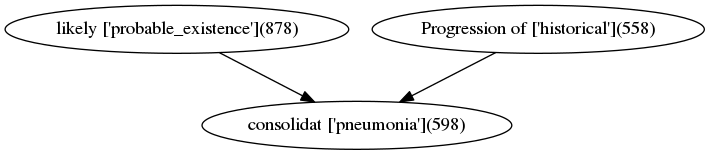

report,classification
"Progression of ground-glass opacities to consolidation predominantly in the upper lobes, likely toxicity or hypersensitivity to recently instituted medication. drug-related toxicity. If bronchoalveolar lavage or transbronchial biopsy is contemplated, the lung apices demonstrate the largest areas of involvement. (Over) DATE: [**3294-3-23**] 8:47 AM CT CHEST W/CONTRAST; CT 100CC NON IONIC CONTRAST Clip # [**Clip Number (Radiology) 3519**] Reason: evolution of ground glass opacities, ? DAH, ? CHF Admitting Diagnosis: PROSTATE CANCER;PNEUMONIA Contrast: OPTIRAY Amt: 100 ______________________________________________________________________________ FINAL REPORT (Cont)",pneumonia (Positive/Certain/Acute)


In [64]:
view_markup(data, colors)